<a href="https://colab.research.google.com/github/Naveenbsm/Deep-Learning-Applications-in-Retinal-Disease-Detection/blob/main/H_Deep_Learning_Applications_in_Retinal_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Necessary Libraries

In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import VGG16
!pip install keras-tuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.6 MB/s eta 0:00:00


<ipython-input-1-150d4d9e4bed>:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## Loading the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
"""## Loading the data"""

file_dir = '/content/drive/MyDrive/eyedisease'
folders = os.listdir(file_dir)
file_path =[]
labels = []
for folder in folders:
    sub_folder = os.path.join(file_dir, folder)
    filelist = os.listdir(sub_folder)
    for file in filelist:
        f_path = os.path.join(sub_folder, file)
        file_path.append(f_path)
        labels.append(folder)
df = pd.DataFrame({"filepath": file_path, "label": labels})
df.head()

,filepath,label
0,/content/drive/MyDrive/eyedisease/glaucoma/_43...,glaucoma
1,/content/drive/MyDrive/eyedisease/glaucoma/127...,glaucoma
2,/content/drive/MyDrive/eyedisease/glaucoma/197...,glaucoma
3,/content/drive/MyDrive/eyedisease/glaucoma/_11...,glaucoma
4,/content/drive/MyDrive/eyedisease/glaucoma/149...,glaucoma


In [4]:
def load_dataset(file_dir):
    """
    Load file paths and labels from the dataset directory

    Args:
        file_dir (str): Path to the dataset directory

    Returns:
        pd.DataFrame: DataFrame with file paths and labels
    """
    file_paths = []
    labels = []

    folders = os.listdir(file_dir)
    for folder in folders:
        sub_folder = os.path.join(file_dir, folder)
        filelist = os.listdir(sub_folder)

        for file in filelist:
            f_path = os.path.join(sub_folder, file)
            file_paths.append(f_path)
            labels.append(folder)

    return pd.DataFrame({"filepath": file_paths, "label": labels})

df = load_dataset(file_dir)
df.shape

(4217, 2)

## Exloratory Data Analysis

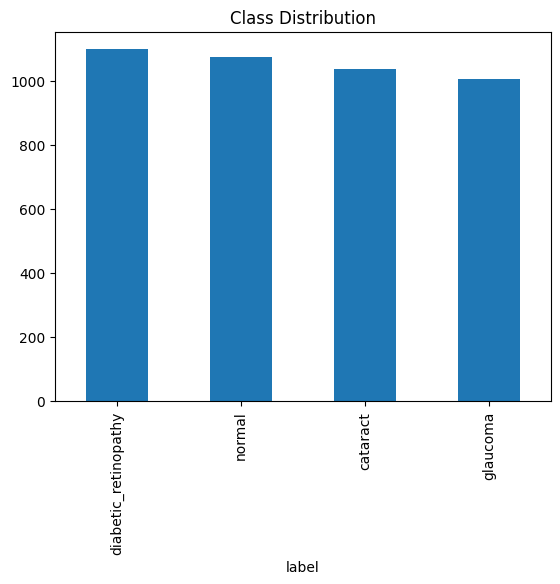

In [5]:
df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.show()


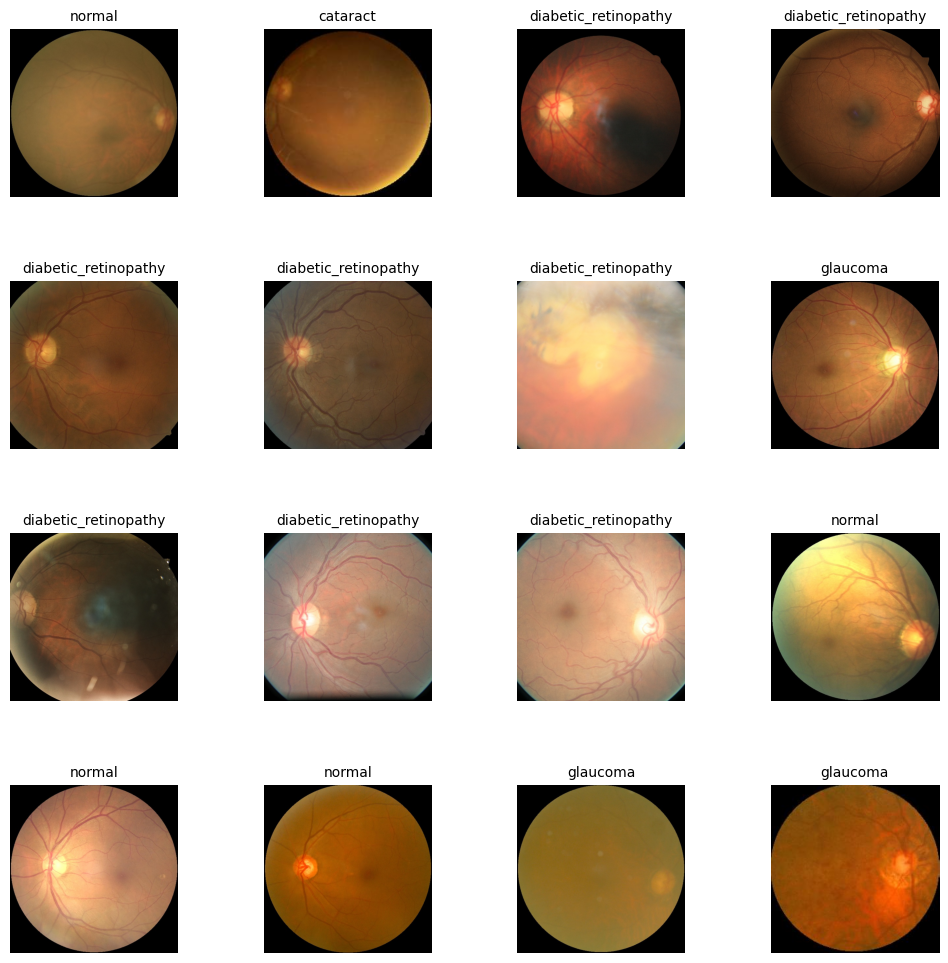

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Randomly sample 16 images from the dataset
sampled_images = df.sample(16).reset_index()

# Set up the grid
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Loop through the grid and plot each image
for i, ax in enumerate(axes.flat):
    img_path = sampled_images['filepath'][i]
    label = sampled_images['label'][i]
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(label, fontsize=10)
    ax.axis('off')  # Hide axis for better visualization

plt.show()


## Data Preprocessing

In [7]:
def preprocess_image(image_path, target_size=(128, 128)):
    """
    Preprocess single image with enhancement techniques

    Args:
        image_path (str): Path to the image file
        target_size (tuple): Desired output image size

    Returns:
        np.ndarray: Preprocessed image
    """
    try:
        # Read image with error handling
        image = cv2.imread(image_path)

        # Check if image is loaded successfully
        if image is None:
            print(f"Warning: Unable to read image {image_path}")
            return None

        # Convert to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize with aspect ratio preservation
        h, w = image.shape[:2]
        aspect_ratio = w / h

        # Resize maintaining aspect ratio
        if w > h:
            new_w = target_size[0]
            new_h = int(new_w / aspect_ratio)
        else:
            new_h = target_size[1]
            new_w = int(new_h * aspect_ratio)

        resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # Create blank canvas
        canvas = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)

        # Calculate positioning to center the image
        y_start = (target_size[1] - new_h) // 2
        x_start = (target_size[0] - new_w) // 2

        # Place resized image on canvas
        canvas[y_start:y_start+new_h, x_start:x_start+new_w] = resized

        # Convert to float and normalize
        normalized = canvas.astype(np.float32) / 255.0

        return normalized

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

In [8]:
def prepare_dataset(file_dir, test_size=0.2, random_state=42):
    """
    Prepare and preprocess the entire dataset

    Args:
        file_dir (str): Path to the dataset directory
        test_size (float): Proportion of dataset for testing
        random_state (int): Random seed for reproducibility

    Returns:
        tuple: Preprocessed and split dataset
    """
    # Load dataset
    df = load_dataset(file_dir)

    # Preprocess images with error handling
    processed_images = []
    processed_labels = []

    for path, label in zip(df['filepath'], df['label']):
        img = preprocess_image(path)
        if img is not None:
            processed_images.append(img)
            processed_labels.append(label)

    # Convert to numpy array
    X = np.array(processed_images)

    # Encode labels
    label_encoder = {label: idx for idx, label in enumerate(sorted(set(processed_labels)))}
    y = np.array([label_encoder[label] for label in processed_labels])

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    return X_train, X_test, y_train, y_test, label_encoder

In [9]:

def data_augmentation(image, num_augmentations=4):
    """
    Perform data augmentation on a single image
        Args:
        image (np.ndarray): Input image
        num_augmentations (int): Number of augmentations to generate

    Returns:
        list: Augmented images
    """
    augmented_images = [image]

    # Geometric Transformations
    # 1. Horizontal Flip
    flipped = cv2.flip(image, 1)
    augmented_images.append(flipped)

    # 2. Rotations
    for angle in [15, -15]:
        # Rotation matrix
        center = (image.shape[1] // 2, image.shape[0] // 2)
        rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, rot_matrix, (image.shape[1], image.shape[0]))
        augmented_images.append(rotated)

    # Color/Intensity Transformations
    # 3. Brightness adjustment
    brightness_low = np.clip(image * 1.2, 0, 1)
    brightness_high = np.clip(image * 0.8, 0, 1)
    augmented_images.extend([brightness_low, brightness_high])

    return augmented_images

In [10]:
def augment_training_data(X_train, y_train):
    """
    Augment training data

    Args:
        X_train (np.ndarray): Training images
        y_train (np.ndarray): Training labels

    Returns:
        tuple: Augmented images and labels
    """
    augmented_images = []
    augmented_labels = []

    for img, label in zip(X_train, y_train):
        # Original image
        augmented_images.append(img)
        augmented_labels.append(label)

        # Generate augmentations
        aug_imgs = data_augmentation(img)
        augmented_images.extend(aug_imgs[1:])  # Skip the first (original) image
        augmented_labels.extend([label] * (len(aug_imgs) - 1))

    return np.array(augmented_images), np.array(augmented_labels)

In [11]:
file_dir = '/content/drive/MyDrive/eyedisease'

# Prepare dataset
X_train, X_test, y_train, y_test, label_encoder = prepare_dataset(file_dir)

# Optional: Apply data augmentation
X_train_aug, y_train_aug = augment_training_data(X_train, y_train)

# Print shapes and details
print("Original training data shape:", X_train.shape)
print("Augmented training data shape:", X_train_aug.shape)
print("Label Encoding:", label_encoder)

Original training data shape: (3373, 128, 128, 3)
Augmented training data shape: (20238, 128, 128, 3)
Label Encoding: {'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}


## Development of CNN, Transfer Learning, and CNN-LSTM models

In [12]:
def create_cnn_model(hp):
    model = models.Sequential()

    # First convolutional layer
    model.add(layers.Conv2D(
        hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),
        (3, 3),
        activation='relu',
        input_shape=(128, 128, 3)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Second convolutional layer
    model.add(layers.Conv2D(
        hp.Int('conv_2_filter', min_value=64, max_value=256, step=64),
        (3, 3),
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Third convolutional layer
    model.add(layers.Conv2D(
        hp.Int('conv_3_filter', min_value=128, max_value=512, step=128),
        (3, 3),
        activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # First dense layer
    model.add(layers.Dense(
        hp.Int('dense_1_units', min_value=64, max_value=512, step=64),
        activation='relu'
    ))
    model.add(layers.Dropout(
        hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)
    ))

    # Second dense layer
    model.add(layers.Dense(
        hp.Int('dense_2_units', min_value=32, max_value=256, step=32),
        activation='relu'
    ))
    model.add(layers.Dropout(
        hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)
    ))

    # Output layer
    model.add(layers.Dense(len(label_encoder), activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [13]:
def create_transfer_learning_model(hp):
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(128, 128, 3)
    )
    base_model.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_1_units', min_value=64, max_value=512, step=64), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(layers.Dense(hp.Int('dense_2_units', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(layers.Dense(len(label_encoder), activation='softmax'))

    model.compile(
        optimizer=optimizers.Adam(hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [14]:
def create_cnn_lstm_model(hp):
    model = models.Sequential()
    model.add(layers.Conv2D(hp.Int('conv_1_filter', min_value=32, max_value=128, step=32), (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(hp.Int('conv_2_filter', min_value=64, max_value=256, step=64), (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(hp.Int('conv_3_filter', min_value=128, max_value=512, step=128), (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Reshape((-1, 128)))
    model.add(layers.LSTM(hp.Int('lstm_1_units', min_value=64, max_value=256, step=64), return_sequences=True))
    model.add(layers.LSTM(hp.Int('lstm_2_units', min_value=32, max_value=128, step=32)))
    model.add(layers.Dense(hp.Int('dense_1_units', min_value=64, max_value=512, step=64), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(layers.Dense(hp.Int('dense_2_units', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(layers.Dense(len(label_encoder), activation='softmax'))

    model.compile(
        optimizer=optimizers.Adam(hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

## Model Testing and Evaluation

In [15]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from kerastuner.tuners import RandomSearch

def train_and_evaluate_single_model(model_func, model_name, X_train, X_test, y_train, y_test):
    """
    Hyperparameter tune, train, and evaluate a single model
    """
    print(f"\n{'='*50}")
    print(f"Training and Evaluating {model_name}")
    print(f"{'='*50}")

    # Prepare data
    num_classes = len(np.unique(y_train))
    y_train_cat = to_categorical(y_train, num_classes=num_classes)
    y_test_cat = to_categorical(y_test, num_classes=num_classes)

    # Hyperparameter Tuning
    print("\nPerforming Hyperparameter Tuning...")
    tuner = RandomSearch(
        model_func,
        objective='val_accuracy',
        max_trials=5,
        executions_per_trial=1,
        directory=f'hp_tuning_{model_name}',
        project_name=model_name
    )

    tuner.search(
        X_train, y_train_cat,
        epochs=10,
        validation_split=0.2,
        verbose=1
    )

    # Get best hyperparameters
    best_hps = tuner.get_best_hyperparameters(1)[0]
    print("\nBest Hyperparameters:")
    for param, value in best_hps.values.items():
        print(f"{param}: {value}")

    # Get best model
    best_model = tuner.get_best_models(1)[0]

    # Print model summary
    print("\nModel Architecture:")
    best_model.summary()

    # Train the model with best hyperparameters
    print("\nTraining Model with Best Hyperparameters...")
    history = best_model.fit(
        X_train, y_train_cat,
        epochs=20,
        validation_split=0.2,
        verbose=1
    )

    # Model Evaluation
    print("\nEvaluating Model Performance...")
    y_pred = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test_cat, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    roc_auc = roc_auc_score(y_test_cat, y_pred, multi_class='ovr', average='weighted')

    # Print evaluation metrics
    print("\nModel Performance Metrics:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    plt.close()

    return best_model, history


Trial 5 Complete [00h 00m 56s]
val_accuracy: 0.7940740585327148

Best val_accuracy So Far: 0.8429629802703857
Total elapsed time: 00h 05m 43s

Best Hyperparameters:
conv_1_filter: 64
conv_2_filter: 256
conv_3_filter: 384
dense_1_units: 128
dropout_1: 0.2
dense_2_units: 128
dropout_2: 0.30000000000000004
learning_rate: 1e-05

Model Architecture:


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 256)         │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 384)         │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 384)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 75264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       9,633,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,688,388 (40.77 MB)

 Trainable params: 10,686,980 (40.77 MB)

 Non-trainable params: 1,408 (5.50 KB)


Training Model with Best Hyperparameters...
Epoch 1/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - accuracy: 0.8590 - loss: 0.3725 - val_accuracy: 0.8444 - val_loss: 0.4183
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.8576 - loss: 0.3684 - val_accuracy: 0.8341 - val_loss: 0.4214
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.8727 - loss: 0.3353 - val_accuracy: 0.8637 - val_loss: 0.3832
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.8894 - loss: 0.2917 - val_accuracy: 0.8696 - val_loss: 0.4063
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.8959 - loss: 0.2848 - val_accuracy: 0.8548 - val_loss: 0.4076
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9009 - loss: 0.2743 - val_accuracy: 0.8548 - val_loss: 0.3987
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9228 - loss: 0.2276 - val_accuracy: 0.8356 - val_loss: 0.4857
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0

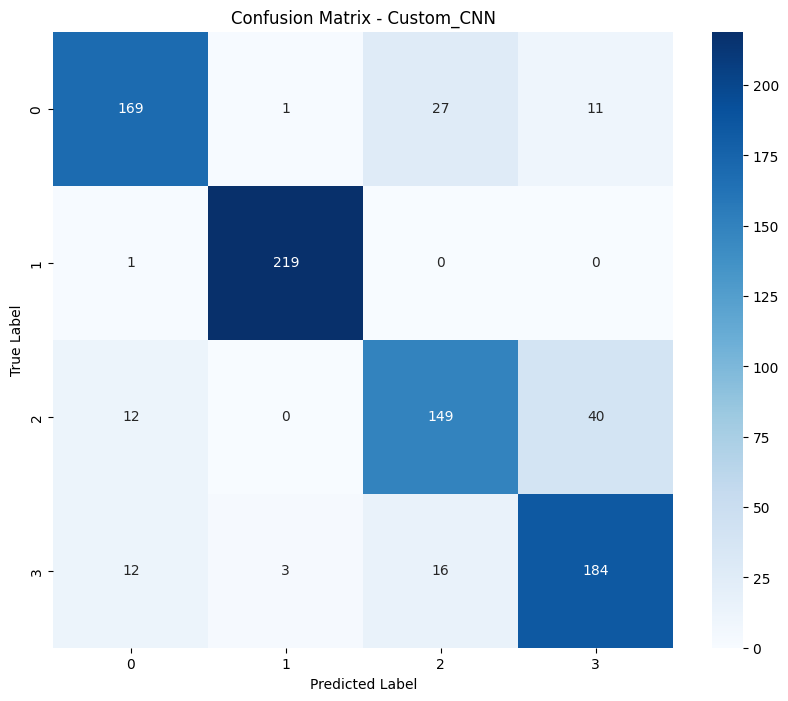

In [16]:
# Prepare your dataset (assuming you have these functions from before)
file_dir = '/content/drive/MyDrive/eyedisease'
X_train, X_test, y_train, y_test, label_encoder = prepare_dataset(file_dir)

# 1. Train and Evaluate Custom CNN
print("\nProcessing Custom CNN Model...")
cnn_model, cnn_history = train_and_evaluate_single_model(
    create_cnn_model,
    "Custom_CNN",
    X_train, X_test,
    y_train, y_test
)

Trial 5 Complete [00h 00m 54s]
val_accuracy: 0.8459259271621704

Best val_accuracy So Far: 0.8459259271621704
Total elapsed time: 00h 04m 38s

Best Hyperparameters:
dense_1_units: 384
dropout_1: 0.30000000000000004
dense_2_units: 64
dropout_2: 0.30000000000000004
learning_rate: 0.0001

Model Architecture:


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 384)                 │       3,146,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,885,700 (68.23 MB)

 Trainable params: 3,171,012 (12.10 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


Training Model with Best Hyperparameters...
Epoch 1/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.8189 - loss: 0.4310 - val_accuracy: 0.8430 - val_loss: 0.4179
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.8506 - loss: 0.3734 - val_accuracy: 0.8415 - val_loss: 0.3945
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.8398 - loss: 0.4060 - val_accuracy: 0.8356 - val_loss: 0.4029
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.8470 - loss: 0.3765 - val_accuracy: 0.8533 - val_loss: 0.3768
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.8431 - loss: 0.3511 - val_accuracy: 0.8622 - val_loss: 0.3763
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.8504 - loss: 0.3666 - val_accuracy: 0.8607 - val_loss: 0.3704
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.8569 - loss: 0.3355 - val_accuracy: 0.8548 - val_loss: 0.3928
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.

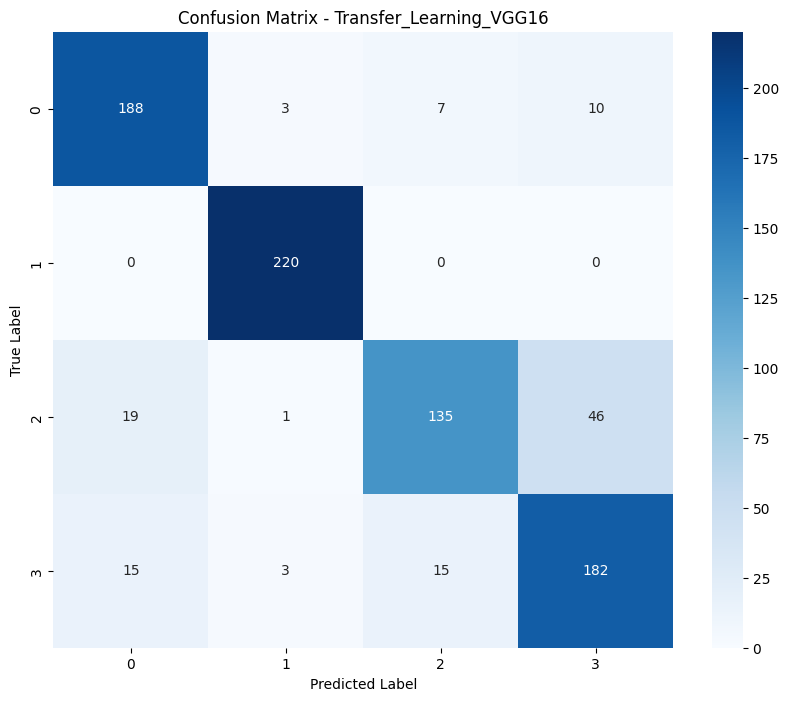

In [17]:
# 2. Train and Evaluate Transfer Learning Model
print("\nProcessing Transfer Learning Model...")
transfer_model, transfer_history = train_and_evaluate_single_model(
    create_transfer_learning_model,
    "Transfer_Learning_VGG16",
    X_train, X_test,
    y_train, y_test
)

Trial 5 Complete [00h 01m 17s]
val_accuracy: 0.448888897895813

Best val_accuracy So Far: 0.6029629707336426
Total elapsed time: 00h 05m 09s

Best Hyperparameters:
conv_1_filter: 32
conv_2_filter: 64
conv_3_filter: 128
lstm_1_units: 192
lstm_2_units: 128
dense_1_units: 512
dropout_1: 0.4
dense_2_units: 224
dropout_2: 0.2
learning_rate: 0.0001

Model Architecture:


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 196, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 196, 192)            │         246,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 224)                 │         114,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             900 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 685,988 (2.62 MB)

 Trainable params: 685,988 (2.62 MB)

 Non-trainable params: 0 (0.00 B)


Training Model with Best Hyperparameters...
Epoch 1/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.6086 - loss: 0.8132 - val_accuracy: 0.6163 - val_loss: 0.8349
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6294 - loss: 0.7703 - val_accuracy: 0.6296 - val_loss: 0.8113
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6597 - loss: 0.7187 - val_accuracy: 0.6533 - val_loss: 0.7858
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6618 - loss: 0.7201 - val_accuracy: 0.6311 - val_loss: 0.7906
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6606 - loss: 0.7163 - val_accuracy: 0.6370 - val_loss: 0.7711
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6453 - loss: 0.7190 - val_accuracy: 0.6504 - val_loss: 0.7563
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6745 - loss: 0.6973 - val_accuracy: 0.6415 - val_loss: 0.7545
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6

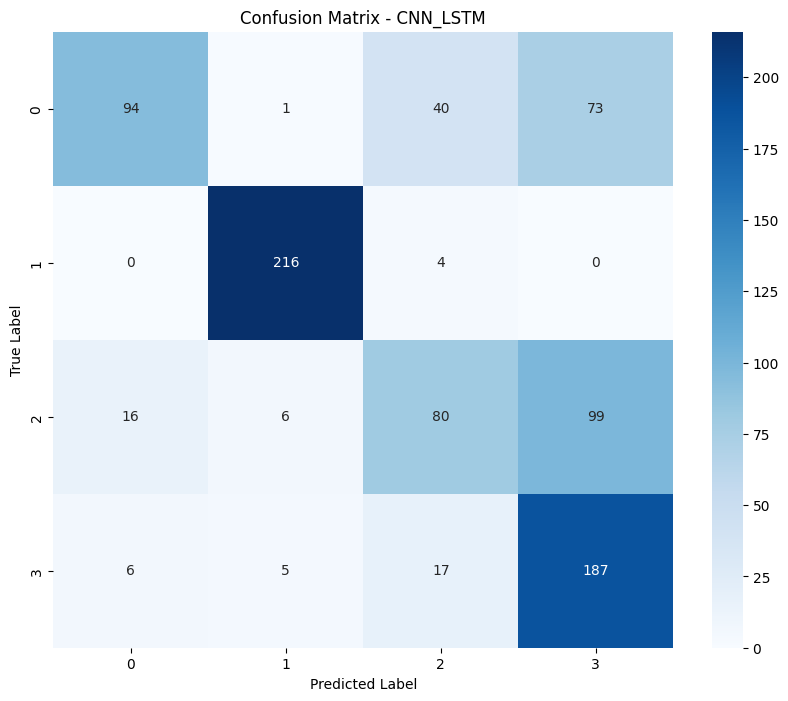

In [18]:

# 3. Train and Evaluate CNN-LSTM Model
print("\nProcessing CNN-LSTM Model...")
cnn_lstm_model, cnn_lstm_history = train_and_evaluate_single_model(
    create_cnn_lstm_model,
    "CNN_LSTM",
    X_train, X_test,
    y_train, y_test
)